# CPSC 330 - Applied Machine Learning 

## Homework 4: Logistic regression, hyperparameter optimization 
### Associated lectures: [Lectures 7, 8](https://github.com/UBC-CS/cpsc330-2022W2) 

**Due date: Feb 10, 11:59pm**


In [1]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["font.size"] = 16

from sklearn.dummy import DummyClassifier
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import (
    GridSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.tree import DecisionTreeClassifier

## Instructions 
<hr>
rubric={points:6}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330-2022W2/blob/main/docs/homework_instructions.md). 

**You may work with a partner on this homework and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- **Be kind** and respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

_Note: The assignments will get gradually more open-ended as we progress through the course. In many cases, there won't be a single correct solution. Sometimes you will have to make your own choices and your own decisions (for example, on what parameter values to use when they are not explicitly provided in the instructions). Use your own judgment in such cases and justify your choices, if necessary._

<br><br><br><br>

## Exercise 1: Implementing `DummyClassifier` 
<hr>
rubric={points:25}

In this course (unlike CPSC 340) you will generally **not** be asked to implement machine learning algorihtms (like logistic regression) from scratch. However, this exercise is an exception: you will implement the simplest possible classifier, `DummyClassifier`.

As a reminder, `DummyClassifier` is meant as a baseline and is generally the worst possible "model" you could "fit" to a dataset. All it does is predict the most popular class in the training set. So if there are more 0s than 1s it predicts 0 every time, and if there are more 1s than 0s it predicts 1 every time. For `predict_proba` it looks at the frequencies in the training set, so if you have 30% 0's 70% 1's it predicts `[0.3 0.7]` every time. Thus, `fit` only looks at `y` (not `X`).

Below you will find starter code for a class called `MyDummyClassifier`, which has methods `fit()`, `predict()`, `predict_proba()` and `score()`. Your task is to fill in those four functions. To get your started, I have given you a `return` statement in each case that returns the correct data type: 
- `fit` can return nothing, 
- `predict` returns an array whose size is the number of examples, 
- `predict_proba` returns an array whose size is the number of examples x 2, and 
- `score` returns a number.

The next code block has some tests you can use to assess whether your code is working. 

I suggest starting with `fit` and `predict`, and making sure those are working before moving on to `predict_proba`. For `predict_proba`, you should return the frequency of each class in the training data, which is the behaviour of `DummyClassifier(strategy='prior')`. Your `score` function should call your `predict` function. Again, you can compare with `DummyClassifier` using the code below.

To simplify this question, you can assume **binary classification**, and furthermore that these classes are **encoded as 0 and 1**. In other words, you can assume that `y` contains only 0s and 1s. The real `DummyClassifier` works when you have more than two classes, and also works if the target values are encoded differently, for example as "cat", "dog", "mouse", etc.

In [2]:
class MyDummyClassifier:
    """
    A baseline classifier that predicts the most common class.
    The predicted probabilities come from the relative frequencies
    of the classes in the training data.

    This implementation only works when y only contains 0s and 1s.
    """

    def fit(self, X, y):     
        count_0 = 0;
        count_1 = 0;
        
        for idx in y:
            if idx == 0:
                count_0 += 1
            else:
                count_1 += 1
        
        self.count_0 = count_0
        self.count_1 = count_1
        self.class_0_prob = self.count_0 / (self.count_0 + self.count_1)
        
        return None

    def predict(self, X):
        
        return np.zeros(X.shape[0], dtype=int) + (self.count_1 >= self.count_0)

    def predict_proba(self, X):
        
        return np.array([[self.class_0_prob, 1.0 - self.class_0_prob]] * X.shape[0])

    def score(self, X, y):
        
        return np.mean(self.predict(X) == y)

Below are some tests for `predict` using randomly generated data. You may want to run the cell a few times to make sure you explore the different cases (or automate this with a loop or random seeds).

In [3]:
# For testing, generate random data
n_train = 101
n_valid = 21
d = 5
X_train_dummy = np.random.randn(n_train, d)
X_valid_dummy = np.random.randn(n_valid, d)
y_train_dummy = np.random.randint(2, size=n_train)
y_valid_dummy = np.random.randint(2, size=n_valid)

my_dc = MyDummyClassifier()
sk_dc = DummyClassifier(strategy="prior")

my_dc.fit(X_train_dummy, y_train_dummy)
sk_dc.fit(X_train_dummy, y_train_dummy)

assert np.array_equal(my_dc.predict(X_train_dummy), sk_dc.predict(X_train_dummy))
assert np.array_equal(my_dc.predict(X_valid_dummy), sk_dc.predict(X_valid_dummy))

Below are some tests for `predict_proba`.

In [4]:
assert np.allclose(
    my_dc.predict_proba(X_train_dummy), sk_dc.predict_proba(X_train_dummy)
)
assert np.allclose(
    my_dc.predict_proba(X_valid_dummy), sk_dc.predict_proba(X_valid_dummy)
)

Below are some tests for `score`.

In [5]:
assert np.isclose(
    my_dc.score(X_train_dummy, y_train_dummy), sk_dc.score(X_train_dummy, y_train_dummy)
)
assert np.isclose(
    my_dc.score(X_valid_dummy, y_valid_dummy), sk_dc.score(X_valid_dummy, y_valid_dummy)
)

<br><br><br><br>

## Exercise 2: Trump Tweets
<hr>

For the rest of this assignment we'll be looking at a [dataset of Donald Trump's tweets](https://www.kaggle.com/austinreese/trump-tweets) as of June 2020. You should start by downloading the dataset. Unzip it and move the file `realdonaldtrump.csv` into this directory. As usual, please do not submit the dataset when you submit the assignment. 

In [6]:
tweets_df = pd.read_csv("realdonaldtrump.csv", index_col=0)
tweets_df.head()

,link,content,date,retweets,favorites,mentions,hashtags
id,,,,,,,
1698308935,https://twitter.com/realDonaldTrump/status/169...,Be sure to tune in and watch Donald Trump on L...,2009-05-04 13:54:25,510,917,NaN,NaN
1701461182,https://twitter.com/realDonaldTrump/status/170...,Donald Trump will be appearing on The View tom...,2009-05-04 20:00:10,34,267,NaN,NaN
1737479987,https://twitter.com/realDonaldTrump/status/173...,Donald Trump reads Top Ten Financial Tips on L...,2009-05-08 08:38:08,13,19,NaN,NaN
1741160716,https://twitter.com/realDonaldTrump/status/174...,New Blog Post: Celebrity Apprentice Finale and...,2009-05-08 15:40:15,11,26,NaN,NaN
1773561338,https://twitter.com/realDonaldTrump/status/177...,"""My persona will never be that of a wallflower...",2009-05-12 09:07:28,1375,1945,NaN,NaN


In [7]:
tweets_df.shape

(43352, 7)

We will be trying to predict whether a tweet will go "viral", defined as having more than 10,000 retweets:

In [8]:
y = tweets_df["retweets"] > 10_000

To make predictions, we'll be using only the content (text) of the tweet. 

In [9]:
X = tweets_df["content"]

For the purpose of this assignment, you can ignore all the other columns in the original dataset.

#### 2(a) ordering the steps
rubric={points:8}

Let's start by building a model using `CountVectorizer` and `LogisticRegression`. The code required to do this has been provided below, but in the wrong order. 

- Rearrange the lines of code to correctly fit the model and compute the cross-validation score. 
- Add a short comment to each block to describe what the code is doing.

In [10]:
# Step 1: Make the test, train splits for X and y respectively
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=111)

# Step 2: prepare CountVectorizer with parameter
countvec = CountVectorizer(stop_words="english")

# Step 3: prepare LogisticRegression with parameter
lr = LogisticRegression(max_iter=1000)

# Step 4: make a pipeline using the CountVectorizer and LogisticRegression from the previous steps
pipe = make_pipeline(countvec, lr)

# Step 5: Obtain cross validation results and store it as a DataFrame into cross_val_results
cross_val_results = pd.DataFrame(
    cross_validate(pipe, X_train, y_train, return_train_score=True)
)

# Step 6: Display the mean cross validation scores
cross_val_results.mean()




fit_time       1.696172
score_time     0.113988
test_score     0.898475
train_score    0.967952
dtype: float64

<br><br>

#### 2(b) Cross-validation fold sub-scores
rubric={points:3}

Above we averaged the scores from the 5 folds of cross-validation. 

- Print out the 5 individual scores. 
    - (Reminder: `sklearn` calls them `"test_score"` but they are really (cross-)validation scores.)
- Are the 5 scores close to each other or spread far apart? 
  - (This is a bit subjective, answer to the best of your ability.)
- How does the size of this dataset (number of rows) compare to the cities dataset we have been using in class? How does this relate to the different sub-scores from the 5 folds?

In [11]:
print("The 5 individual scores are: ")

cross_val_results["test_score"]

The 5 individual scores are: 


0    0.895587
1    0.898047
2    0.896971
3    0.897893
4    0.903876
Name: test_score, dtype: float64

<br><br>The 5 scores are close to each other differing only by within +/- 0.006.

The size of this dataset is much larger than the cities dataset we have been working with. The entire cities dataset size is approximately 200 while the entire tweets dataset is approximately 40000 which means that the tweets dataset is roughly 200 times bigger. This also means that the results we obtain are much more accurate and reliable than the cities toy dataset. To place more emphasis on the last statement, the sub-scores from the 5 folds performs better than the cities dataset since our model is more able to generalize to more unseen data.

#### 2(c) baseline
rubric={points:3}

By the way, are these scores any good? 

- Run `DummyClassifier` (or `MyDummyClassifier`!) on this dataset.
- Compare the `DummyClassifier` score to what you got from logistic regression above. Does logistic regression seem to be doing anything useful?
- Is it necessary to use `CountVectorizer` here? Briefly explain.

In [12]:
myDumClassifier = MyDummyClassifier()

myDumClassifier.fit(X_train, y_train)
myDumClassifier.predict(X_train)

print("The score is: ")
myDumClassifier.score(X_train, y_train)

The score is: 


0.7353140185766132

<br>
The logistic regression score is much better than the score obtained by our dummy classifier. This means that logistic regression does indeed seem to be doing something useful.

It is not necessary to use `CountVectorizer` here as the `DummyClassifier` only predicts the outcome based on the most frequent values of `y`. It does not go into any features into `X`, so there is no need to use `CountVectorizer` to convert the presence of each word to a binary representation. 
<br>

#### 2(d) probability scores
rubric={points:5}

Here we train a logistic regression classifier on the entire training set: 

(Note: this is relying on the `pipe` variable from 2(a) - you'll need to redefine it if you overwrote that variable in between.)

In [13]:
pipe.fit(X_train, y_train);

Using this model, find the tweet in the **test set** with the highest predicted probability of being viral. Print out the tweet and the associated probability score.

Reminder: you are free to reuse/adapt code from lecture. Please add in a small attribution, e.g. "From Lecture 7".

In [14]:
# Adapted from Lecture 7

probs = pipe.predict_proba(X_test)[
    :, 1
]

high_pos = np.argmax(probs)

tweet = X_test.iloc[high_pos]

print(tweet)

print("True target: %s\n" % (y_test.iloc[high_pos]))
print("Predicted target: %s\n" % (pipe.predict(X_test.iloc[[high_pos]])[0]))
print("Prediction probability: %.11f" % (probs[high_pos]))

“FBI texts have revealed anti-Trump Bias.” @ FoxNews Big News, but the Fake News doesn’t want to cover. Total corruption - the Witch Hunt has turned out to be a scam! At some point soon the Mainstream Media will have to cover correctly, too big a story!
True target: True

Predicted target: True

Prediction probability: 0.99999969367


<br><br>

#### 2(e) coefficients
rubric={points:4}

We can extract the `CountVectorizer` and `LogisticRegression` objects from the `make_pipeline` object as follows:


In [15]:
vec_from_pipe = pipe.named_steps["countvectorizer"]
lr_from_pipe = pipe.named_steps["logisticregression"]

Using these extracted components above, display
- the 5 words with the highest coefficients and 
- the 5 words with the smallest coefficients.

In [16]:
feature_names = vec_from_pipe.get_feature_names_out()
coefficient = lr_from_pipe.coef_[0]

highest_top5 = sorted(zip(feature_names, coefficient), key=lambda x: x[1], reverse=True)[:5]
lowest_top5 = sorted(zip(feature_names, coefficient), key=lambda x: x[1], reverse=False)[:5]

print("Top 5 words with highest coefficients:")
for word, coefficient in highest_top5:
    print(f"{word}: {coefficient}")

print("\nTop 5 words with lowest coefficients:")
for word, coefficient in lowest_top5:
    print(f"{word}: {coefficient}")

Top 5 words with highest coefficients:
obamagate: 2.8540547261218108
harassment: 2.725221745786584
coronavirus: 2.5291426480498536
mini: 2.527216339762021
fake: 2.4839599836438016

Top 5 words with lowest coefficients:
realdonaldtrump: -3.133447625995737
trump2016pic: -2.6666314792633807
barackobama: -2.5304671683767626
donaldtrump: -2.1845837268402626
celebapprentice: -2.1061742977131037


<br><br>

#### 2(f) Running a cross-validation fold without sklearn tools 
rubric={points:8}

Sklearn provides a lot of useful tools like `make_pipeline` and `cross_validate`, which are awesome. But with these fancy tools it's also easy to lose track of what is actually happening under the hood. 

**Your tasks:**

1. Compute logistic regression's validation score on the first fold, that is, train on 80% and validate on 20% of the training data (`X_train`) without using sklearn `Pipeline` or `cross_validate` or `cross_val_score`. Store the score of the fold in a variable called `fold_score`. Recall that `cross_validation` in `sklearn` does not shuffle the data by default.    

You should start with the following `CountVectorizer` and `LogisticRegression` objects, as well as `X_train` and `y_train` (which you should further split with `train_test_split` and `shuffle=False`):

In [17]:
#countvec = CountVectorizer(stop_words="english")
#lr = LogisticRegression(max_iter=1000)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, shuffle=False)

countvec = CountVectorizer(stop_words="english")
lr = LogisticRegression(max_iter=1000)

X_train_vec = countvec.fit_transform(X_train)
X_val_vec = countvec.transform(X_val)

lr.fit(X_train_vec, y_train)

fold_score = lr.score(X_val_vec, y_val)
fold_score

0.9038905120713517

<br><br><br><br>

## Exercise 3: hyperparameter optimization
<hr>

#### 3(a)
rubric={points:4}

The following code varies the `max_features` hyperparameter of `CountVectorizer` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `max_features`. It also prints the results. 

Based on the plot/output, what value of `max_features` seems best? Briefly explain.

> **Note:** the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

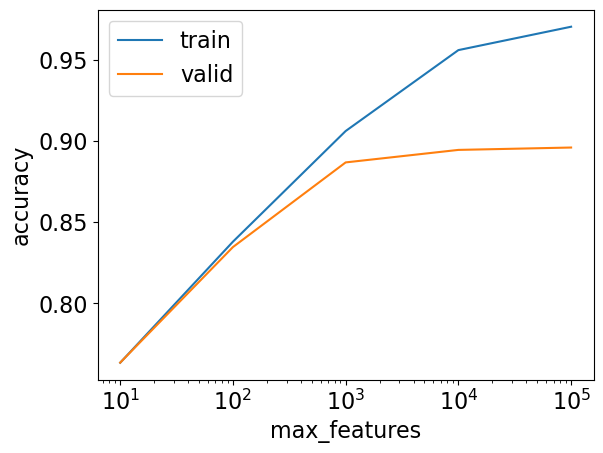

In [18]:
train_scores = []
cv_scores = []

max_features = [10, 100, 1000, 10_000, 100_000]

for mf in max_features:
    #     print(mf)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=mf),
        LogisticRegression(max_iter=1000),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)
    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(max_features, train_scores, label="train")
plt.semilogx(max_features, cv_scores, label="valid")
plt.legend()
plt.xlabel("max_features")
plt.ylabel("accuracy");

In [19]:
pd.DataFrame({"max_features": max_features, "train": train_scores, "cv": cv_scores})

,max_features,train,cv
0,10,0.763581,0.763639
1,100,0.837992,0.834685
2,1000,0.906030,0.886740
3,10000,0.955788,0.894429
4,100000,0.970166,0.895890


Based on the plot and the output above, `max_features=1000` seems to perform the best. The validation scores started to level off at `max_features=1000` while the training scores kept increasing, which means that the approximation error beyond `max_features=1000` start to substantially increase. Therefore, among all the hyperparameters listed above, the value of `max_features=1000` seems the best.

<br><br>

#### 3(b)
rubric={points:6}

The following code varies the `C` hyperparameter of `LogisticRegression` and makes a plot (with the x-axis on a log scale) that shows train/cross-validation scores vs. `C`. 

Based on the plot, what value of `C` seems best?

> **Note:** the code may take a minute or two to run. You can uncomment the `print` statement if you want to see it show the progress.

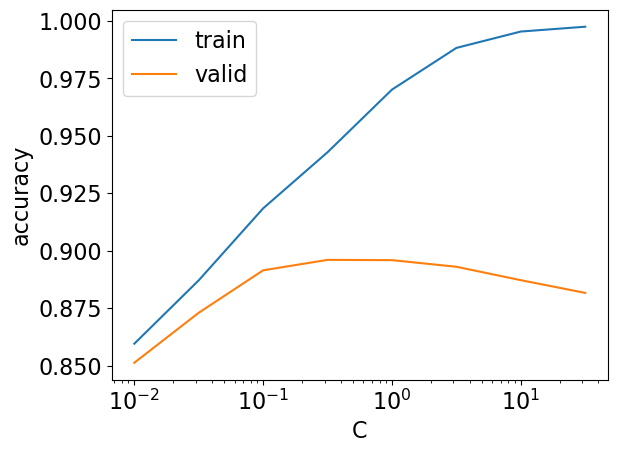

In [20]:
train_scores = []
cv_scores = []

C_vals = 10.0 ** np.arange(-2, 2, 0.5)

for C in C_vals:
    #     print(C)
    pipe = make_pipeline(
        CountVectorizer(stop_words="english", max_features=None),
        LogisticRegression(max_iter=1000, C=C),
    )
    cv_results = cross_validate(pipe, X_train, y_train, return_train_score=True)

    train_scores.append(cv_results["train_score"].mean())
    cv_scores.append(cv_results["test_score"].mean())

plt.semilogx(C_vals, train_scores, label="train")
plt.semilogx(C_vals, cv_scores, label="valid")
plt.legend()
plt.xlabel("C")
plt.ylabel("accuracy");

In [21]:
pd.DataFrame({"C": C_vals, "train": train_scores, "cv": cv_scores})

,C,train,cv
0,0.010000,0.859502,0.851217
1,0.031623,0.887105,0.872977
2,0.100000,0.918448,0.891469
3,0.316228,0.942899,0.896006
4,1.000000,0.970166,0.895890
5,3.162278,0.988322,0.893007
6,10.000000,0.995454,0.887163
7,31.622777,0.997549,0.881627


Based on the plot, having C set to $10^-1$ would be the best as it has the highest accuracy or cv score. For the same reason as explained in question 3A, increasing the exponent beyond $10^-1$ would increase the gap between training and validation accuracy thus result in overfitting.

<br><br>

#### 3(c) Hyperparameter optimization 
rubric={points:10}

Start with the pipeline `pipe` below.

**Your tasks:**
- Create a `GridSearchCV` object named `grid_search` to jointly optimize `max_features` of `CountVectorizer` and `C` of `LogisticRegression` across all the combinations of values we tried above. 
- What are the best values of `max_features` and `C` according to your grid search? 
- Store them in variables `best_max_features` and `best_C`, respectively.  
- Store the best score returned by the grid search in a variable called `best_score`. 

> The code might be a bit slow here. Setting `n_jobs=-1` should speed it up if you have a multi-core processor.

In [22]:
# We create a param_grid to hold values to go through
param_grid = {
    "countvectorizer__max_features": [10, 100, 1000, 10000, 100000],
    "logisticregression__C": [0.01, 0.1, 1, 10, 100]
}

# this pipe is adapted from Question 3B
pipe = make_pipeline(
        CountVectorizer(stop_words="english"),
        LogisticRegression(max_iter=1000),
)

# make the model and fit with the train set
grid_search_model = GridSearchCV(pipe, param_grid, n_jobs=-1)
grid_search_model.fit(X_train, y_train)

best_max_features = grid_search_model.best_params_["countvectorizer__max_features"]
best_C = grid_search_model.best_params_["logisticregression__C"]
best_score = grid_search_model.best_score_

print("The best max_features: ", best_max_features)
print("The best C: ", best_C)
print("The best score: ", best_score)

The best max_features:  100000
The best C:  1
The best score:  0.8958902469762254


#### 3(d) Discussion 
rubric={points:4}

- Do the best values of hyperparameters found by Grid Search agree with what you found in 3(a) and 3(b)? 
- **Generally speaking**, _should_ these values agree with what you found in parts  3.1 and 3.2? Why or why not? 

The best hyperparameters' value found via `GridSearchCV` are as follows: max_features = 100000 and C = 1.

The best hyperparameters' value found above in Questions 3A and 3B are as follows: max_features = 10000 and C = 1.

They only differ by the max_features values: `GridSearchCV` yielded 10^(5) while Questions 3A was reasoned to be 10^(4).

In general, the values yielded by `GridSearchCV` should agree with the values found in Questions 3A and 3B because `GridSearchCV` is an exhuastive search through many values, often producing the best values (to maximize the cross-validation score). Furthermore, if we use a strategy in selecting hyperparameters different from `scikit-learn`'s implementation, that is to find the pair of hyperparameter values that maximizes the cross-validation score, we will end up with different hyperparameter values. 

#### 3(e) Test score
rubric={points:2}

- Evaluate your final model on the test set. Store the test accuracy in the variable called `test_score`.

In [23]:
countvec = CountVectorizer(stop_words="english", max_features=best_max_features)
model_lr = LogisticRegression(max_iter=1000, C=best_C)

X_train_vec = countvec.fit_transform(X_train)
X_test_vec = countvec.transform(X_test)

model_lr.fit(X_train_vec, y_train)
test_score = model_lr.score(X_test_vec, y_test)

test_score

0.8998892784646614

#### 3(f) Discussion of Test Score
rubric={points:4}

- How does your test accuracy compare to your validation accuracy? 
- If they are different: do you think this is because you "overfitted on the validation set", or simply random luck?

The test accuracy is higher than the validation accuracy by approximately 0.004. This may be because of random luck.

## Exercise 4: Very short answer questions
rubric={points:8}

Each question is worth 2 points. Max 2 sentences per answer.

1. What is the problem with calling `fit_transform` on your test data with `CountVectorizer`? 
2. If you could only access one of `predict` or `predict_proba`, which one would you choose? Briefly explain.
3. What are two advantages of `RandomizedSearchCV` over `GridSearchCV`?
4. Why is it important to follow the Golden Rule? If you violate it, will that give you a worse classifier?

1. `fit_transform` on the test data will fit on the test data and then transform the test data using the model. Because calling `fit_transform` on the test data will fit on the test data, it is violating the Golden Rule.
2. If I could only access one of `predict` or `predict_proba` I would choose `predict_proba` because it will tell me the probabilities of the classes (soft predictions). This information is useful for determining how confident a model is for predictions to better understand the model while `predict` is simply just a hard prediction without any further details.
3. The two advantages of `RandomizedSearchCV` over `GridSearchCV` are that `RandomizedSearchCV` is faster and that factoring in more parameters has no effect on the performance and efficiency unlike that of `GridSearchCV`.
4. It is extremely important to follow the Golden Rule because the test set is supposed to be representative of unknown data and thus using it for fitting will mean that it is not very good to be generalized to other new unknown datasets. This will result in a worse classifier if the unseen deployment data has high variability.

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 